# PCA From Scratch

The goal is to get a better understanding behind PCA, including the math.

We will build PCA using linear algebra and compair the results to SKLearn's PCA class

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.decomposition import PCA

### We will stay with $R^2$ for now

This is mainly to be able to easily visualize the scatter plots.

But this mean that we might be avoiding complexities of higher orders (i.e. Right=hand and Left-hand rules).

## Build a data cloud with some degree or corrlation between X and Y

Slope: -2.8982
Y-Intercept: 39.8882


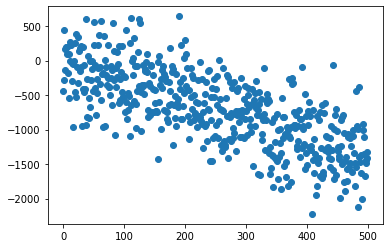

In [2]:
max_x = 500
slope_range = [.1, 10]
slope_direction = np.random.choice([-1,1])
intercept_range = [-80, 80]
residual_var = 100
x = np.arange(max_x)
m = np.random.uniform(*slope_range) * slope_direction
b = np.random.uniform(*intercept_range)
y_variation_factor = 1.3
y = m * x + b + np.random.normal(0, residual_var, len(x)) * m * y_variation_factor
print(f'Slope: {m:.4f}\nY-Intercept: {b:.4f}')
plt.scatter(x, y)

### We want to center the two features, but not change their scale

We will be using the covariance and not the corrlation for out Eigendecomposition.  This will preserve the magnature of the variances for each feature

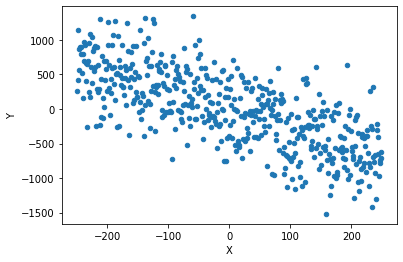

In [3]:
df = pd.DataFrame({'X':x, 'Y':y})
df.X = (df.X - df.X.mean()) #/ df.X.std()
df.Y = (df.Y - df.Y.mean()) #/ df.Y.std()
df.plot.scatter('X', 'Y')

#### We can simply divide each feature by it's standard deviation to standarize the dataset if we wanted

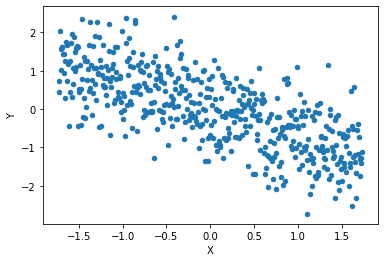

In [4]:
df_std = df.copy()
df_std.X = df_std.X / df_std.X.std()
df_std.Y = df_std.Y / df_std.Y.std()
df_std.plot.scatter('X', 'Y')

### We want to use covariance, but lets quickly look at the corrlation first

Note that the corrlation of our centered dataframe is the same as the covariance of our standardized dataframe.

The non-diagional values are the same and is the Pearson corrlation cooefficent.  i.e. how much linear corrleation there is between 2 variables.  A value of 1 means $Y = X$.  A value of 0 means there is no corrlation between the 2 factors.

Here, the random approach will give a Pearson value of around 75%, so their should be a strong linear relationship between X and Y, but not perfect.

In [5]:
display(df.corr())
display(df_std.cov())

,X,Y
X,1.000000,-0.715478
Y,-0.715478,1.000000


,X,Y
X,1.000000,-0.715478
Y,-0.715478,1.000000


### Use Pandas to get covariance matrix

Note: We need to do this on our centered only dataframe

In [7]:
df.cov()

,X,Y
X,20875.000000,-57673.173987
Y,-57673.173987,311264.187802


### We don't have to use Pandas to get the covariance

The caculation is very simply since we already centered the data.

_Note: We will use Bessel's correction here to match what Numpy uses._

### Variation

$variance_X = \sum \frac{\left ( X - \overline{X} \right )^2}{n-1}$

But since we centered the data, $\overline{X} = 0$

So we are left with:

$\sum \frac{\left ( X\right )^2}{n-1}$

### Covariation

$covariance = \sum \frac{\left ( X - \overline{X} \right ) * \left ( Y - \overline{Y} \right )}{n-1}$

Covariation is basically the same equation, but we use $X*Y vs. X^2$

But like the variance, $\overline{X} = 0$ and $\overline{Y} = 0$

This leaves us with:

$\sum \frac{X * Y}{n-1}$


In [24]:
variance_X = (df.X * df.X).sum() / (len(df) - 1)
covariance = (df.X * df.Y).sum() / (len(df) - 1)
variance_Y = (df.Y * df.Y).sum() / (len(df) - 1)

covariance_matrix = np.array([
                                [variance_X, covariance], 
                                [covariance, variance_Y]]
                            )

print('Manual Covariance Matrix:')
display(pd.DataFrame(covariance_matrix, index=['X', 'Y'], columns=['X', 'Y']))

print('\nPandas Covariance Matrix:')
df.cov()

Manual Covariance Matrix:


,X,Y
X,20875.000000,-57673.173987
Y,-57673.173987,311264.187802



Pandas Covariance Matrix:


,X,Y
X,20875.000000,-57673.173987
Y,-57673.173987,311264.187802


#### We can also get the covariance matrix by doing matrix multiplication of the features and it's transpose.

All the matrix multiplication is doing is summing up all the $X*X, X*Y, Y*Y$ values, so it is doing the same thing as above.

In [36]:
pd.DataFrame(np.matmul(df.transpose().values , df.values) / (len(df) - 1), index=['X', 'Y'], columns=['X', 'Y'])

,X,Y
X,20875.000000,-57673.173987
Y,-57673.173987,311264.187802


## Eigendecomposition

And Eigenvector is any vector from a vector space that after a linear transformation only changed by scalar multiplication.

This means we need 2 elements, a vector space and a linear transformation.

- Our **Vector Space** is going to be $R^2$ is is our two features **(X,Y)**.

- The **Linear Transformation** is going to be our **Covariance Matrix**.

The Covariance Matrix is derived directly from our data set, so we are NOT adding any addational information that doesn't already exist in our data set.

Why use the covariance matrix (CVM) as our transformation?  CVM is a square symetric matrix who's diagional values are the variances, and the other values are the covariances. The coverances reflect the degree relationship between 2 features.

To see what kind of linear transformation the CVM produces, let's start with a CVM with 0 covariance.  

$\begin{pmatrix}1 & 0 \\ 0 & 1 \end{pmatrix}$

Here, not only did we zero out the covariance, we made the variance for both X and Y = 1.

This is the identity matrix.  So transforming our data set with this CVM would product no changes.

Now let's take the same matrix, but make the variance of X = 2 and the variance of Y = 3:

$\begin{pmatrix}2 & 0 \\ 0 & 3 \end{pmatrix}$

Transforming our data set with this CVM would scale X by 2 and Y by 3.  But this CVM would not product any rotation of the data.

Now, let's add a some between X and Y:

$\begin{pmatrix}2 & 1 \\ 1 & 3 \end{pmatrix}$

The addation of non-zero covariances to the CVM adds rotation.  For example, an (X,Y) of (1,1) would be transformed to a new vector of (3,4).  (1,1) is a vector with a $45^{\circ}$ angle.  (3,4) is a vector with a $~37^{\circ}$ angle.

In [8]:
def reverseEigenVectors(eigen_unit_vectors):
    return np.array([eigen_unit_vectors[1], eigen_unit_vectors[0]])

In [9]:
eigen_values, eigen_unit_vectors = np.linalg.eigh(df.cov())
print(eigen_values)

#sort by eigenvalue
if eigen_values[1] > eigen_values[0]:
    eigen_unit_vectors = reverseEigenVectors(eigen_unit_vectors)

eigen_unit_vectors

[  9840.06693583 322299.12086654]


array([[-0.18792662,  0.98218307],
       [-0.98218307, -0.18792662]])

In [10]:
pca = PCA(n_components=2)
pca.fit(df)
pca.components_

array([[ 0.18792662, -0.98218307],
       [ 0.98218307,  0.18792662]])

#### The eigenvalues can change the direction of the eigen unit vectors, so what direction the unit vectors take is not critical
i.e. eigenvectors that are parallel or antiparallel make no difference since any vector on this line is an eigenvector

#### Since we want to compare our from scratch PCA with SKLearn's, we want to make sure both eigenvalues are in the same direction

In [11]:
negate_1 = False
if np.sign(pca.components_[0,0]) != np.sign(eigen_unit_vectors[0,0]):
    eigen_unit_vectors[0,:] *= -1
    negate_1 = True

negate_2 = False
if np.sign(pca.components_[1,0]) != np.sign(eigen_unit_vectors[1,0]):
    eigen_unit_vectors[1,:] *= -1
    negate_2 = True
  
    
print(f'SKLearn:\n {pca.components_}\n')
print(f'From Scratch:\n {eigen_unit_vectors}')

SKLearn:
 [[ 0.18792662 -0.98218307]
 [ 0.98218307  0.18792662]]

From Scratch:
 [[ 0.18792662 -0.98218307]
 [ 0.98218307  0.18792662]]


In [12]:
eigen_weighted_vectors = eigen_unit_vectors.copy()
eigen_weighted_vectors[:,0] *= eigen_values[0]
eigen_weighted_vectors[:,1] *= eigen_values[1]

eigen_weighted_vectors

array([[   1849.21048629, -316556.74061144],
       [   9664.74717098,   60568.5833152 ]])

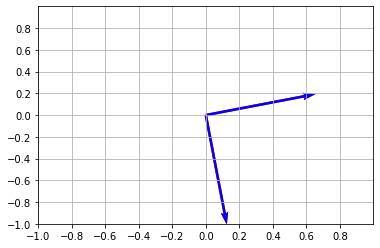

In [13]:
origin = [0], [0] # origin point
V = np.array(eigen_unit_vectors)
PC = np.array(pca.components_)
plt.quiver(*origin, V[:,0], V[:,1], color='r', scale=3)
plt.quiver(*origin, PC[:,0], PC[:,1], color='b', scale=3)
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.xticks(np.arange(-1, 1, .2))
plt.yticks(np.arange(-1, 1, .2))
plt.grid()
plt.show()

Negated First EigenVector: True
Negated Second EigenVecor: True


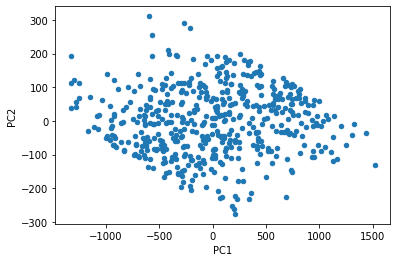

In [14]:
print(f'Negated First EigenVector: {negate_1}\nNegated Second EigenVecor: {negate_2}')
if negate_1 != negate_2:
    df_pca_scratch = df.copy()
    df_pca_scratch = np.matmul(df_pca_scratch, eigen_unit_vectors)
    df_pca_scratch.columns=['PC1', 'PC2']
else:
    df_pca_scratch = df[['Y', 'X']].copy()
    df_pca_scratch = np.matmul(df_pca_scratch, eigen_unit_vectors)
    df_pca_scratch.columns=['PC2', 'PC1']

df_pca_scratch.plot.scatter('PC1', 'PC2')

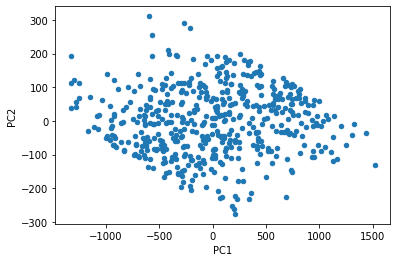

In [15]:
df_pca_skl = pd.DataFrame(pca.transform(df), columns=['PC1', 'PC2'])
# display(df_pca_skl)
df_pca_skl.plot.scatter('PC1', 'PC2')